# Feature Analysis for kNN

In [153]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from knn_preprocessing import knn_preprocessing


# set random state for reproducibility
kwargs = dict(random_state=42)

In [154]:
# Load Datasets
movies = pd.read_csv('../../data/preprocessed/movies_id_updated.csv', sep=',')
actors = pd.read_csv('../../data/raw/actors.csv', sep=',')
countries = pd.read_csv('../../data/raw/countries.csv', sep=',')
directors = pd.read_csv('../../data/raw/directors.csv', sep=',')
genres = pd.read_csv('../../data/raw/genres.csv', sep=',')
locations = pd.read_csv('../../data/raw/locations.csv', sep=',')
movie_tags = pd.read_csv('../../data/raw/movie_tags.csv', sep=',')
ratings = pd.read_csv('../../data/preprocessed/ratings_clean_std_0.csv', sep=',')
tags =  pd.read_csv('../../data/raw/tags.csv', sep=',')
omdb = pd.read_csv('../../data/preprocessed/omdb_cleaned.csv')

In [155]:
omdb.columns

Index(['Title', 'Year', 'Rated', 'Runtime', 'Writer', 'Plot', 'Language',
       'imdbRating', 'imdbVotes', 'imdbID', 'Rotten Tomatoes', 'Metacritic',
       'Series', 'Released_season', 'Released_month', 'Released_day',
       'PG_Rating', 'Available_languages', 'Oscars_won', 'Oscars_nominated',
       'Golden_globe_won', 'Golden_globe_nominated'],
      dtype='object')

In [156]:
omdb = omdb[['Year','Runtime', 'Language',
       'imdbRating', 'imdbVotes', 'imdbID', 'Rotten Tomatoes', 'Metacritic',
       'Series', 'Released_season', 'Released_month', 'Released_day',
       'PG_Rating', 'Available_languages', 'Oscars_won', 'Oscars_nominated',
       'Golden_globe_won', 'Golden_globe_nominated']]

In [157]:
omdb.head()

,Year,Runtime,Language,imdbRating,imdbVotes,imdbID,Rotten Tomatoes,Metacritic,Series,Released_season,Released_month,Released_day,PG_Rating,Available_languages,Oscars_won,Oscars_nominated,Golden_globe_won,Golden_globe_nominated
0,1995.0,81.0,['English'],8.3,852896.0,tt0114709,10.0,9.5,0,4.0,11.0,22.0,0.0,1,0.0,3.0,0.0,0.0
1,1995.0,104.0,"['English', ' French']",7.0,294340.0,tt0113497,5.4,3.9,0,1.0,12.0,15.0,1.0,2,0.0,0.0,0.0,0.0
2,1993.0,103.0,['English'],7.0,41401.0,tt0107050,6.3,5.3,0,1.0,12.0,25.0,2.0,1,0.0,0.0,0.0,0.0
3,1995.0,124.0,['English'],5.9,9222.0,tt0114885,5.6,NaN,0,1.0,12.0,22.0,3.0,1,0.0,0.0,0.0,0.0
4,1995.0,106.0,['English'],6.0,33005.0,tt0113041,4.8,4.9,0,1.0,12.0,8.0,1.0,1,0.0,0.0,0.0,1.0


In [158]:
# Add movies which could not be retrieved by omdb

# Dropping the 10 almost empty movies
indices = omdb[omdb['imdbRating'].isna()]['imdbID'].index
for i in indices:
    omdb = omdb.drop([i], axis=0, )

# Fill NaN Runtime
omdb.loc[:, 'Runtime'] = omdb.loc[:, 'Runtime'].fillna(omdb.loc[:, 'Runtime'].median())
# Fill NaN for imdbVotes
omdb.loc[:, 'imdbVotes'] = omdb.loc[:, 'imdbVotes'].fillna(omdb.loc[:, 'imdbVotes'].median())
# for i in range (4,16):
# omdb.iloc[:,i] = omdb.iloc[:,i].fillna(omdb.iloc[:,i].median())

omdb = omdb.rename(columns={"Rotten Tomatoes": "RottenTomatoes"})

# Replace RT Score with Metacritic if NaN
# where Replace values where the condition is False.
omdb['RottenTomatoes'] = omdb['RottenTomatoes'].where(~omdb['RottenTomatoes'].isna(), omdb['Metacritic'])

# Replace Metacritic with RT Scroe if NaN
omdb['Metacritic'].where(~omdb['Metacritic'].isna(), omdb['RottenTomatoes'])

# Fill remaining with mean()
omdb['RottenTomatoes'] = omdb['RottenTomatoes'].where(~omdb['RottenTomatoes'].isna(), omdb['RottenTomatoes'].mean())
omdb['Metacritic'] = omdb['Metacritic'].where(~omdb['Metacritic'].isna(), omdb['Metacritic'].mean())

merged_data = ratings.merge(omdb, how='left', on='imdbID')
merged_data = merged_data.drop(columns={'Unnamed: 0'})

# Replace for Series, PG and awards NaN with 0 and handle accordingly
for i in ['PG_Rating', 'Available_languages', 'Oscars_won', 'Oscars_nominated',
   'Golden_globe_won', 'Golden_globe_nominated']:
    merged_data.loc[:, i] = merged_data.loc[:, i].fillna(0)

# convert imdbID from string to float
merged_data['imdbID'] = merged_data['imdbID'].str.replace(r'tt', '')
merged_data['imdbID'] = merged_data['imdbID'].astype(float)

# Jetzt einfach ma5 mean() eingefüllt
print(merged_data.columns)
for i in range(6, 16):
    merged_data.iloc[:, i] = merged_data.iloc[:, i].fillna(merged_data.iloc[:, i].median())

for i in range(15, 19):
     merged_data.iloc[:, i] = merged_data.iloc[:, i].fillna(0)


Index(['user_id', 'imdbID', 'rating', 'Year', 'Runtime', 'Language',
       'imdbRating', 'imdbVotes', 'RottenTomatoes', 'Metacritic', 'Series',
       'Released_season', 'Released_month', 'Released_day', 'PG_Rating',
       'Available_languages', 'Oscars_won', 'Oscars_nominated',
       'Golden_globe_won', 'Golden_globe_nominated'],
      dtype='object')


In [159]:
merged_data

,user_id,imdbID,rating,Year,Runtime,Language,imdbRating,imdbVotes,RottenTomatoes,Metacritic,Series,Released_season,Released_month,Released_day,PG_Rating,Available_languages,Oscars_won,Oscars_nominated,Golden_globe_won,Golden_globe_nominated
0,1264,47034.0,3.5,1954.0,96.0,['Japanese'],7.6,27485.0,9.3,7.800000,0.0,2.0,5.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0
1,213,304141.0,2.5,2004.0,142.0,['English'],7.9,524511.0,9.0,8.200000,0.0,3.0,6.0,4.0,1.0,1.0,0.0,2.0,0.0,0.0
2,593,369436.0,3.0,2008.0,88.0,['English'],5.7,61335.0,2.4,4.100000,0.0,4.0,11.0,26.0,2.0,1.0,0.0,0.0,0.0,0.0
3,609,1077258.0,4.0,2007.0,105.0,['English'],7.1,196149.0,7.4,5.780126,0.0,3.0,6.0,13.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1590,52182.0,4.0,1958.0,100.0,['English'],7.4,6337.0,6.9,5.780126,0.0,1.0,2.0,11.0,0.0,1.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787536,1032,83530.0,3.0,1982.0,85.0,['English'],6.2,47327.0,4.2,4.800000,0.0,1.0,12.0,10.0,1.0,1.0,0.0,0.0,0.0,0.0
787537,99,107798.0,3.0,1993.0,141.0,['English'],6.6,73544.0,5.3,5.000000,0.0,1.0,12.0,17.0,2.0,1.0,0.0,0.0,0.0,0.0
787538,333,93857.0,3.0,1987.0,88.0,"['English', ' Spanish']",5.1,12882.0,0.7,2.800000,0.0,3.0,7.0,10.0,2.0,2.0,0.0,0.0,0.0,0.0
787539,49,144168.0,3.0,1999.0,94.0,['English'],6.1,17926.0,7.1,6.500000,0.0,3.0,8.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0


In [160]:
merged_data['Awards'] = merged_data['Oscars_won']+merged_data['Golden_globe_won']+merged_data['Oscars_nominated']+merged_data['Golden_globe_nominated']

In [161]:
merged_data.describe()

,user_id,imdbID,rating,Year,Runtime,imdbRating,imdbVotes,RottenTomatoes,Metacritic,Series,Released_season,Released_month,Released_day,PG_Rating,Available_languages,Oscars_won,Oscars_nominated,Golden_globe_won,Golden_globe_nominated,Awards
count,787541.000000,7.875410e+05,787541.000000,787272.000000,787272.000000,787541.000000,7.875410e+05,787541.000000,787541.000000,787541.000000,787541.000000,787541.000000,787541.000000,787541.000000,787541.000000,787541.000000,787541.000000,787541.000000,787541.000000,787541.000000
mean,692.828912,1.854573e+05,3.438227,1992.360846,114.032130,7.119191,2.369228e+05,7.088473,6.438238,0.002995,2.506875,6.799881,15.868155,2.030359,1.765803,0.481409,0.481287,0.004578,0.066619,1.033892
std,499.428706,1.479920e+05,1.002999,14.389344,24.279886,0.931680,3.175175e+05,2.401364,1.666967,0.054648,1.102796,3.424577,8.461036,1.034206,1.201183,1.264556,1.115085,0.075813,0.321370,1.533121
min,0.000000,4.390000e+02,0.500000,1903.000000,5.000000,1.500000,1.900000e+01,0.000000,0.100000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,274.000000,9.515900e+04,3.000000,1988.000000,98.000000,6.600000,4.243300e+04,5.600000,5.600000,0.000000,1.000000,4.000000,9.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,595.000000,1.186550e+05,3.500000,1997.000000,110.000000,7.200000,1.197590e+05,7.800000,6.400000,0.000000,3.000000,7.000000,16.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1045.000000,2.653070e+05,4.000000,2002.000000,126.000000,7.800000,2.874750e+05,9.000000,7.600000,0.000000,3.000000,10.000000,23.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2112.000000,1.349938e+06,5.000000,2010.000000,608.000000,9.400000,2.238077e+06,10.000000,10.000000,1.000000,4.000000,12.000000,31.000000,4.000000,13.000000,9.000000,9.000000,5.000000,4.000000,9.000000


In [162]:
merged_data = merged_data.drop(columns={'Oscars_won', 'Oscars_nominated',
       'Golden_globe_won', 'Golden_globe_nominated'})

In [163]:
merged_data.dtypes

user_id                  int64
imdbID                 float64
rating                 float64
Year                   float64
Runtime                float64
Language                object
imdbRating             float64
imdbVotes              float64
RottenTomatoes         float64
Metacritic             float64
Series                 float64
Released_season        float64
Released_month         float64
Released_day           float64
PG_Rating              float64
Available_languages    float64
Awards                 float64
dtype: object

In [164]:
merged_data['Language'] = merged_data['Language'].replace(0, 'None')

In [165]:
merged_data

,user_id,imdbID,rating,Year,Runtime,Language,imdbRating,imdbVotes,RottenTomatoes,Metacritic,Series,Released_season,Released_month,Released_day,PG_Rating,Available_languages,Awards
0,1264,47034.0,3.5,1954.0,96.0,['Japanese'],7.6,27485.0,9.3,7.800000,0.0,2.0,5.0,7.0,0.0,1.0,0.0
1,213,304141.0,2.5,2004.0,142.0,['English'],7.9,524511.0,9.0,8.200000,0.0,3.0,6.0,4.0,1.0,1.0,2.0
2,593,369436.0,3.0,2008.0,88.0,['English'],5.7,61335.0,2.4,4.100000,0.0,4.0,11.0,26.0,2.0,1.0,0.0
3,609,1077258.0,4.0,2007.0,105.0,['English'],7.1,196149.0,7.4,5.780126,0.0,3.0,6.0,13.0,0.0,1.0,0.0
4,1590,52182.0,4.0,1958.0,100.0,['English'],7.4,6337.0,6.9,5.780126,0.0,1.0,2.0,11.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787536,1032,83530.0,3.0,1982.0,85.0,['English'],6.2,47327.0,4.2,4.800000,0.0,1.0,12.0,10.0,1.0,1.0,0.0
787537,99,107798.0,3.0,1993.0,141.0,['English'],6.6,73544.0,5.3,5.000000,0.0,1.0,12.0,17.0,2.0,1.0,0.0
787538,333,93857.0,3.0,1987.0,88.0,"['English', ' Spanish']",5.1,12882.0,0.7,2.800000,0.0,3.0,7.0,10.0,2.0,2.0,0.0
787539,49,144168.0,3.0,1999.0,94.0,['English'],6.1,17926.0,7.1,6.500000,0.0,3.0,8.0,4.0,2.0,1.0,0.0


In [166]:
#mlb = preprocessing.MultiLabelBinarizer()

In [167]:
#mlb.fit_transform(merged_data['Language'])

In [168]:
merged_data=merged_data.drop(columns={'Language'})

In [169]:
ratings['user_id'].value_counts()

243     3028
17      2583
20      2525
401     2469
417     2369
        ... 
1578      18
2075      18
1973      18
2063      17
1630      17
Name: user_id, Length: 2113, dtype: int64

In [170]:
user_sample = merged_data.loc[merged_data['user_id'] == 243]

In [171]:
user_sample

,user_id,imdbID,rating,Year,Runtime,imdbRating,imdbVotes,RottenTomatoes,Metacritic,Series,Released_season,Released_month,Released_day,PG_Rating,Available_languages,Awards
8,243,88011.0,3.0,1984.0,106.0,6.9,79986.0,8.4,6.300000,0.0,2.0,3.0,30.0,1.0,3.0,1.0
107,243,93206.0,3.0,1988.0,91.0,7.4,7579.0,8.3,5.780126,0.0,1.0,2.0,1.0,0.0,2.0,0.0
166,243,91396.0,2.0,1986.0,116.0,6.0,9535.0,4.4,5.700000,0.0,3.0,6.0,20.0,1.0,1.0,0.0
282,243,293113.0,0.5,2002.0,73.0,6.8,1837.0,8.7,8.400000,0.0,1.0,12.0,12.0,0.0,1.0,0.0
308,243,114048.0,2.0,1995.0,107.0,5.1,8265.0,3.1,4.800000,0.0,3.0,7.0,28.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785292,243,106582.0,3.5,1993.0,113.0,6.4,116198.0,6.8,6.000000,0.0,2.0,5.0,28.0,3.0,1.0,3.0
785579,243,910970.0,4.0,2008.0,98.0,8.4,963538.0,9.5,9.500000,0.0,3.0,6.0,27.0,0.0,1.0,1.0
785940,243,120824.0,2.0,2001.0,111.0,6.7,31386.0,5.5,4.700000,0.0,1.0,1.0,18.0,3.0,1.0,2.0
786211,243,243135.0,1.5,2000.0,90.0,6.8,3737.0,6.4,5.900000,0.0,3.0,6.0,21.0,3.0,2.0,0.0


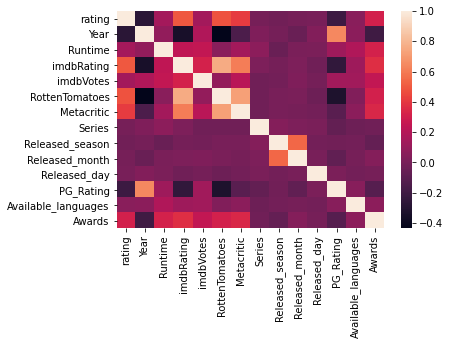

In [183]:
sns.heatmap(user_sample.drop(columns={'user_id','imdbID'}).corr(method='pearson'))

In [184]:
omdb_corr = user_sample.drop(columns={'user_id','imdbID'}).corr(method='pearson')

In [185]:
omdb_corr

,rating,Year,Runtime,imdbRating,imdbVotes,RottenTomatoes,Metacritic,Series,Released_season,Released_month,Released_day,PG_Rating,Available_languages,Awards
rating,1.000000,-0.273862,0.149267,0.497279,0.142729,0.478916,0.414350,-0.001441,-0.017495,-0.001105,0.002398,-0.209146,0.061518,0.311329
Year,-0.273862,1.000000,0.087496,-0.342480,0.190166,-0.435621,-0.144141,0.028438,-0.006154,-0.044552,0.037510,0.645672,0.064131,-0.194591
Runtime,0.149267,0.087496,1.000000,0.242032,0.251483,0.060359,0.146185,0.071203,-0.046158,0.010634,0.018307,0.130512,0.188233,0.321113
imdbRating,0.497279,-0.342480,0.242032,1.000000,0.317842,0.763790,0.611491,0.022499,-0.004367,0.018751,-0.020789,-0.249609,0.125889,0.366782
imdbVotes,0.142729,0.190166,0.251483,0.317842,1.000000,0.096634,0.216711,-0.021655,-0.010672,0.026076,-0.004683,0.137593,0.138672,0.249961
RottenTomatoes,0.478916,-0.435621,0.060359,0.763790,0.096634,1.000000,0.723160,-0.022573,0.003976,0.008266,-0.035667,-0.319537,0.034947,0.312793
Metacritic,0.414350,-0.144141,0.146185,0.611491,0.216711,0.723160,1.000000,-0.021154,0.005380,-0.002562,-0.009659,-0.101809,0.068124,0.341602
Series,-0.001441,0.028438,0.071203,0.022499,-0.021655,-0.022573,-0.021154,1.000000,0.046312,0.022272,0.011471,-0.068808,-0.034989,-0.023531
Released_season,-0.017495,-0.006154,-0.046158,-0.004367,-0.010672,0.003976,0.005380,0.046312,1.000000,0.542174,-0.013594,-0.018851,-0.014825,-0.064768
Released_month,-0.001105,-0.044552,0.010634,0.018751,0.026076,0.008266,-0.002562,0.022272,0.542174,1.000000,0.003922,-0.074873,-0.000719,0.041791


In [186]:
omdb_corr = omdb_corr['rating']

In [187]:
omdb_corr

rating                 1.000000
Year                  -0.273862
Runtime                0.149267
imdbRating             0.497279
imdbVotes              0.142729
RottenTomatoes         0.478916
Metacritic             0.414350
Series                -0.001441
Released_season       -0.017495
Released_month        -0.001105
Released_day           0.002398
PG_Rating             -0.209146
Available_languages    0.061518
Awards                 0.311329
Name: rating, dtype: float64

In [188]:
omdb_corr = omdb_corr[ abs(omdb_corr) > 0.1]

In [189]:
omdb_corr

rating            1.000000
Year             -0.273862
Runtime           0.149267
imdbRating        0.497279
imdbVotes         0.142729
RottenTomatoes    0.478916
Metacritic        0.414350
PG_Rating        -0.209146
Awards            0.311329
Name: rating, dtype: float64

So these seem to be the relevant features in omdb.

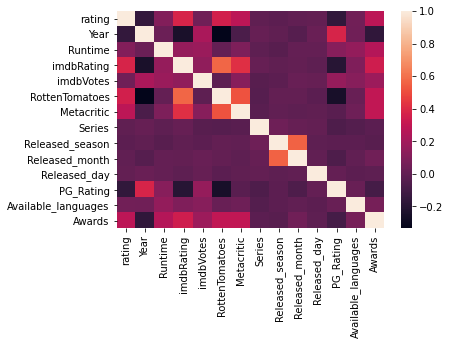

In [128]:
sns.heatmap(user_sample.drop(columns={'user_id','imdbID'}).corr(method='kendall'))

## Correlate MergedData and Actors

In [142]:
actors.head()

,movieID,actorID,actorName,ranking
0,1,annie_potts,Annie Potts,10
1,1,bill_farmer,Bill Farmer,20
2,1,don_rickles,Don Rickles,3
3,1,erik_von_detten,Erik von Detten,13
4,1,greg-berg,Greg Berg,17


In [ ]:
#TODO Encode

In [139]:
#mlb = preprocessing.MultiLabelBinarizer()

In [143]:
#mlb.fit_transform(merged_movies['Language'])